In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像时负号‘-’显示为方块的问题

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # 绘制ROC曲线

#### 导入分箱的数据

In [12]:
data1 = pd.read_csv('../数据/营销模型建模数据3(分箱).csv')
x1 = data1.iloc[:,2:]
y1 = data1.resp
from sklearn.model_selection import train_test_split
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size=0.3,random_state=0)

#### 建立逻辑回归模型

##### 自动化寻找最优参数

In [ ]:
from sklearn.linear_model import LogisticRegression as LR
# 自动化寻找最优参数
# from sklearn.model_selection import GridSearchCV
# import warnings
# warnings.filterwarnings("ignore")

# # 参数设置
# params = {'C':[0.0001, 1, 100, 1000],
#           'max_iter':[1, 10, 100, 500],
#           'class_weight':['balanced', None],
#           'solver':['liblinear','sag','lbfgs','newton-cg']
#          }
# model = LR()
# clf = GridSearchCV(model,param_grid=params,cv=10)
# clf.fit(x1_train,y1_train)

# clf.best_params_ # 查看最佳参数组合

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       936
           1       0.64      0.34      0.45       411

    accuracy                           0.74      1347
   macro avg       0.70      0.63      0.64      1347
weighted avg       0.72      0.74      0.71      1347

[[858  78]
 [271 140]]


Text(0.5, 1.0, 'ROC曲线-逻辑回归')

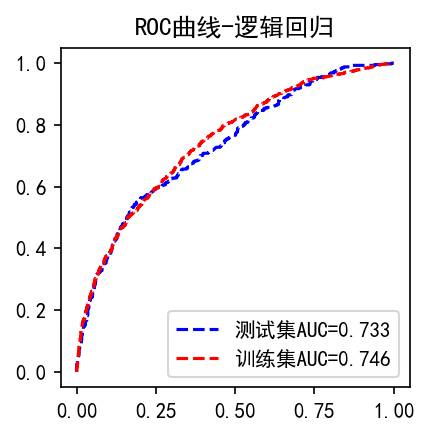

In [13]:
# 构建模型
clf.best_params_ = {'C': 1, 'class_weight': None, 'max_iter': 10, 'solver': 'liblinear'}
model = LR(**clf.best_params_)
model.fit(x1_train,y1_train)

print(metrics.classification_report(y1_test, model.predict(x1_test)))
print(metrics.confusion_matrix(y1_test, model.predict(x1_test)))

# roc、auc计算
fpr_test,tpr_test,th_test = metrics.roc_curve(y1_test,model.predict_proba(x1_test)[:,1]) # 测试集
fpr_train,tpr_train,th_train = metrics.roc_curve(y1_train,model.predict_proba(x1_train)[:,1]) # 训练集
plt.figure(dpi=150,figsize=(3,3))
plt.plot(fpr_test,tpr_test,'b--',label=f'测试集AUC={round(metrics.auc(fpr_test,tpr_test),4)}')
plt.plot(fpr_train,tpr_train,'r--',label=f'训练集AUC={round(metrics.auc(fpr_train,tpr_train),4)}')
plt.legend();plt.title('ROC曲线-逻辑回归')

### 分数转换

##### data1是1998上半年的表现数据

In [14]:
def cal_scale(score,odds,PDO):
    '''
    参数：
        odds: 设定的坏好比
        score: 在这个odds下的分数
        PDO： 好坏翻倍比
        model: 逻辑回归模型
    return：
        A,B
    '''
    B = PDO/np.log(2)
    A = score + B*np.log(odds)
    # base_score = A+B*model.intercept_[0]
    print('B: {:.2f}'.format(B))
    print('A: {:.2f}'.format(A))
    # print('基础分为：{:.2f}'.format(base_score))
    return A,B

def Pre2Score(pre,A,B):
    y = np.log(pre/(1-pre))
    return round(1300-A+B*y) # 这里是用1300- 因为概率越高分数越高

In [15]:
A,B = cal_scale(770,0.05,45) # 假设基础分为50，odds为5%，PDO为10
data1['resp_score_proba'] = model.predict_proba(x1)[:,1]
data1['resp_score'] = data1['resp_score_proba'].map((lambda x:Pre2Score(x,A,B)))
data1['resp_score'].describe()
# data1['resp_score_proba'].map((lambda x:Pre2Score(x,A,B))).describe()

B: 64.92
A: 575.51


count    4490.000000
mean      659.489532
std        63.442373
min       423.000000
25%       616.000000
50%       653.000000
75%       695.000000
max       873.000000
Name: resp_score, dtype: float64

Text(0, 0.5, '频次')

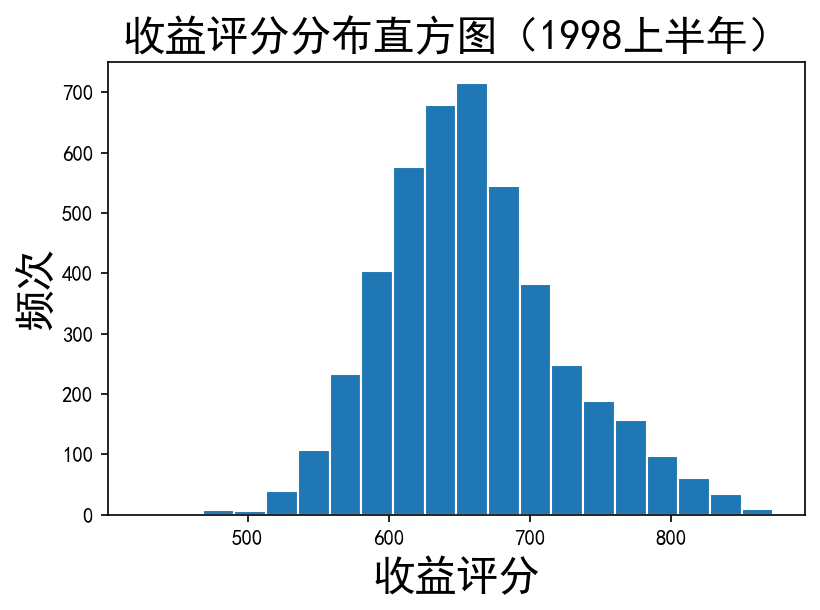

In [16]:
plt.figure(dpi=150)
plt.hist(data1.resp_score,edgecolor='w',bins=20)
plt.title('收益评分分布直方图（1998上半年）',fontsize=20); plt.xlabel('收益评分',fontsize=20); plt.ylabel('频次',fontsize=20)

### 营销细分
高中低的界定，由表现期分箱界定

In [17]:
is_ovd = pd.read_csv('../数据/data_model.csv')
is_ovd_score = pd.read_csv('../数据/风险评分.csv')
data1 = pd.merge(data1,is_ovd.loc[:,['ID','is_ovd']],on='ID',how='left')
data1 = pd.merge(data1,is_ovd_score.loc[:,['ID','score']],on='ID',how='left')
data1.fillna(0,inplace=True)

#### 分箱

In [55]:
from sklearn.tree import DecisionTreeClassifier
def optimal_binning_boundary(x: pd.Series, y: pd.Series,leaf=3, nan: float = -999.) -> list:
    '''
        利用决策树获得最优分箱的边界值列表
        leaf: 最大叶子节点数
    '''
    boundary = []  # 待return的分箱边界值列表
    
    x = x.fillna(nan).values  # 填充缺失值
    y = y.values
    
    clf = DecisionTreeClassifier(criterion='entropy',    #“信息熵”最小化准则划分
                                 max_leaf_nodes=leaf,       # 最大叶子节点数
                                 min_samples_leaf=0.05)  # 叶子节点样本数量最小占比

    clf.fit(x.reshape(-1, 1), y)  # 训练决策树
    
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    threshold = clf.tree_.threshold
    
    for i in range(n_nodes):
        if children_left[i] != children_right[i]:  # 获得决策树节点上的划分边界值
            boundary.append(threshold[i])

    boundary.sort()

    min_x = x.min()
    max_x = x.max() + 0.1  # +0.1是为了考虑后续groupby操作时，能包含特征最大值的样本
    boundary = [min_x] + boundary + [max_x]

    return boundary

def feature_woe_iv(x: pd.Series, y: pd.Series,leaf=3, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
        leaf: 最大叶子节点数
    '''
    x = x.fillna(nan)
    boundary = optimal_binning_boundary(x, y, leaf,nan)        # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)                        # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']                               # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间
    
    grouped = df.groupby('bins')['y']                     # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('总客户数', 'count'),
                             ('坏客户数',   lambda y: (y == 1).sum()),
                             ('好客户数',  lambda y: (y == 0).sum())])

    result_df['好客户占比'] = result_df['好客户数'] / result_df['好客户数'].sum()       # 好客户占比
    result_df['坏客户占比'] = result_df['坏客户数'] / result_df['坏客户数'].sum()          # 坏客户占比
    result_df['组占比'] = result_df['总客户数'] / result_df['总客户数'].sum()    # 总客户占比

    result_df['坏客户率'] = (result_df['坏客户数'] / result_df['总客户数']).apply(lambda x: format(x,'.2%'))             # 坏比率
    
    result_df['woe'] = np.log( result_df['坏客户占比']/result_df['好客户占比'])              # WOE
    result_df['iv'] = ( result_df['坏客户占比'] - result_df['好客户占比']) * result_df['woe']  # IV
    
    print(f"该变量IV = {result_df['iv'].sum()}")
    
    return result_df

#### 收益评分分箱

该变量IV = 0.7475680780038141


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[423.0, 610.5)",980,86,894,0.284351,0.063893,0.218263,8.78%,-1.493000,0.329144
"[610.5, 691.5)",2306,575,1731,0.550573,0.427192,0.513586,24.93%,-0.253726,0.031305
"[691.5, 873.1)",1204,685,519,0.165076,0.508915,0.268151,56.89%,1.125874,0.387119


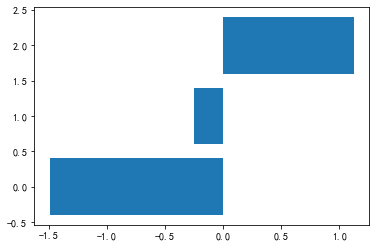

In [57]:
df = feature_woe_iv(data1.resp_score,data1.resp,leaf=3) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df

In [60]:
pd.cut(data1.resp_score,bins=[0,610,690,np.inf]).value_counts().sort_index()

(0.0, 610.0]       980
(610.0, 690.0]    2292
(690.0, inf]      1218
Name: resp_score, dtype: int64

#### 风险评分分箱

该变量IV = 0.521691522915545


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[514.0, 734.5)",360,11.0,349.0,0.078392,0.289474,0.080178,3.06%,1.306346,0.275746
"[734.5, 753.5)",667,10.0,657.0,0.147574,0.263158,0.148552,1.50%,0.578424,0.066856
"[753.5, 872.1)",3463,17.0,3446.0,0.774034,0.447368,0.771269,0.49%,-0.548234,0.179089


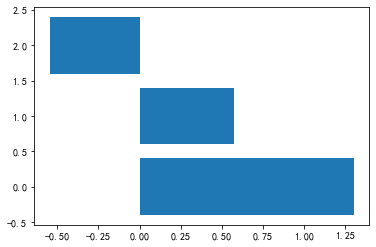

In [62]:
df = feature_woe_iv(data1.score,data1.is_ovd,leaf=3) # leaf: 最大叶子节点数
plt.barh(range(len(df)),df['woe'])
df

In [64]:
pd.cut(data1.score,bins=[0,730,750,np.inf]).value_counts().sort_index()

(0.0, 730.0]       274
(730.0, 750.0]     624
(750.0, inf]      3592
Name: score, dtype: int64

##### 重新定义分界线，eg:637-->640

In [69]:
def feature_woe_iv2(x: pd.Series, y: pd.Series,bins, nan: float = -999.) -> pd.DataFrame:
    '''
        计算变量各个分箱的WOE、IV值，返回一个DataFrame
        leaf: 最大叶子节点数
    '''
    x = x.fillna(nan)
    values,boundary = pd.cut(x,bins=bins,retbins=True)        # 获得最优分箱边界值列表
    df = pd.concat([x, y], axis=1)                        # 合并x、y为一个DataFrame，方便后续计算
    df.columns = ['x', 'y']                               # 特征变量、目标变量字段的重命名
    df['bins'] = pd.cut(x=x, bins=boundary, right=False)  # 获得每个x值所在的分箱区间
    
    grouped = df.groupby('bins')['y']                     # 统计各分箱区间的好、坏、总客户数量
    result_df = grouped.agg([('总客户数', 'count'),
                             ('坏客户数',   lambda y: (y == 1).sum()),
                             ('好客户数',  lambda y: (y == 0).sum())])

    result_df['好客户占比'] = result_df['好客户数'] / result_df['好客户数'].sum()       # 好客户占比
    result_df['坏客户占比'] = result_df['坏客户数'] / result_df['坏客户数'].sum()          # 坏客户占比
    result_df['组占比'] = result_df['总客户数'] / result_df['总客户数'].sum()    # 总客户占比

    result_df['坏客户率'] = (result_df['坏客户数'] / result_df['总客户数']).apply(lambda x: format(x,'.2%'))             # 坏比率
    
    result_df['woe'] = np.log( result_df['坏客户占比']/result_df['好客户占比'])              # WOE
    result_df['iv'] = ( result_df['坏客户占比'] - result_df['好客户占比']) * result_df['woe']  # IV
    
    print(f"该变量IV = {result_df['iv'].sum()}")
    
    return result_df

In [70]:
feature_woe_iv2(data1.resp_score,data1.resp,bins=[0,610,690,np.inf])

该变量IV = 0.7378250861143202


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[0.0, 610.0)",953,82,871,0.277036,0.060921,0.212249,8.60%,-1.514564,0.327319
"[610.0, 690.0)",2302,570,1732,0.550891,0.423477,0.512695,24.76%,-0.263037,0.033515
"[690.0, inf)",1235,694,541,0.172074,0.515602,0.275056,56.19%,1.097411,0.376992


In [72]:
feature_woe_iv2(data1.score,data1.is_ovd,bins=[0,735,755,np.inf])

该变量IV = 0.49963376715571367


,总客户数,坏客户数,好客户数,好客户占比,坏客户占比,组占比,坏客户率,woe,iv
bins,,,,,,,,,
"[0.0, 735.0)",360,11.0,349.0,0.078392,0.289474,0.080178,3.06%,1.306346,0.275746
"[735.0, 755.0)",711,10.0,701.0,0.157457,0.263158,0.158352,1.41%,0.513600,0.054288
"[755.0, inf)",3419,17.0,3402.0,0.764151,0.447368,0.761470,0.50%,-0.535383,0.169600


### 模型监督
1998上半年建模，下半年评分

##### 提取1998下半年数据

In [18]:
data2 = pd.read_csv('../数据/营销模型建模数据3(分箱)1998下半年.csv')
# is_ovd = pd.read_csv('../数据/data_model.csv')
# is_ovd_score = pd.read_csv('../数据/风险评分.csv')
data2 = pd.merge(data2,is_ovd.loc[:,['ID','is_ovd']],on='ID',how='left')
data2 = pd.merge(data2,is_ovd_score.loc[:,['ID','score']],on='ID',how='left')
data2.fillna(0,inplace=True)
# 模型预测概率与分数
data2['resp_score_proba'] = model.predict_proba(data2.loc[:,'Xc_trades_1':'Xn_income_1'])[:,1]
data2['resp_score'] = data2['resp_score_proba'].map((lambda x:Pre2Score(x,A,B)))
data2['resp_score'].describe()
data2['resp_pre'] = data2.resp_score_proba.apply(lambda x: 1 if x>=0.5 else 0)

Text(0, 0.5, '频次')

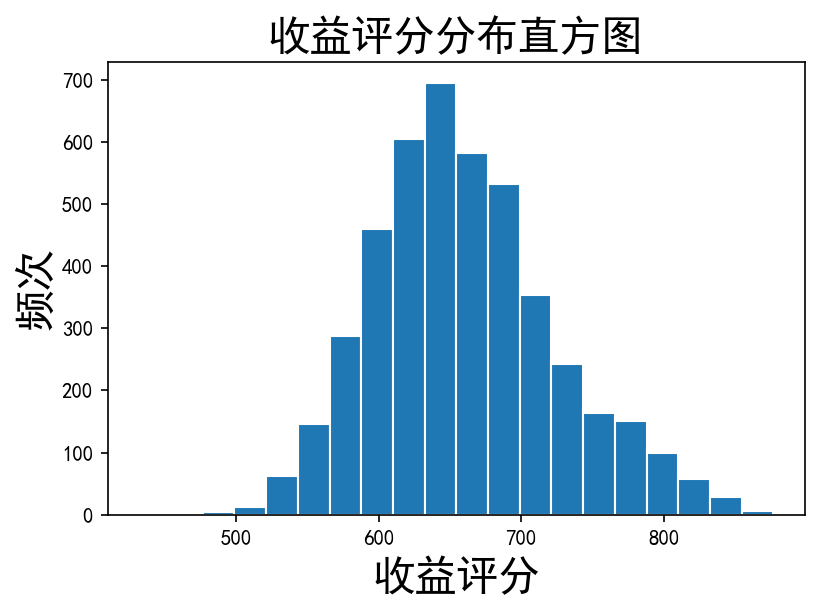

In [19]:
plt.figure(dpi=150)
plt.hist(data2.resp_score,edgecolor='w',bins=20)
plt.title('收益评分分布直方图',fontsize=20); plt.xlabel('收益评分',fontsize=20); plt.ylabel('频次',fontsize=20)

Text(0, 0.5, '频次')

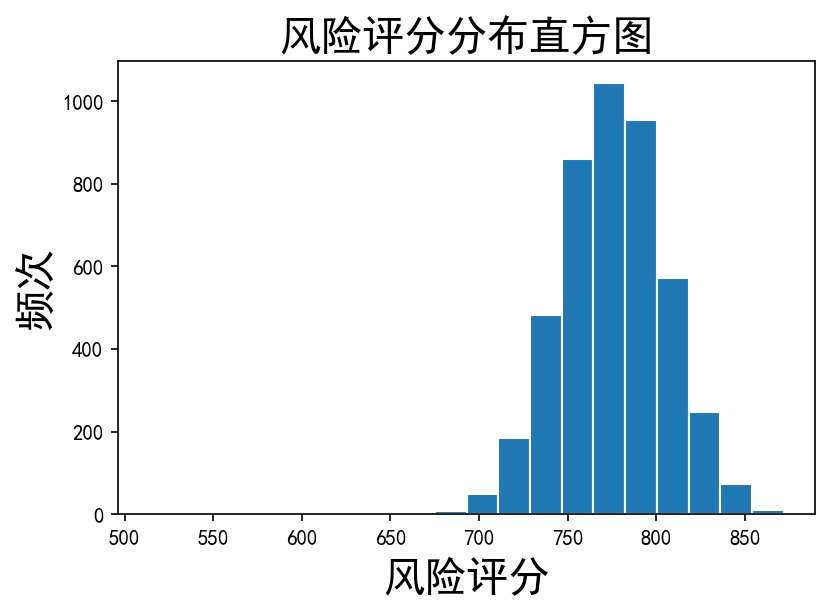

In [20]:
plt.figure(dpi=150)
plt.hist(data2.score,edgecolor='w',bins=20)
plt.title('风险评分分布直方图',fontsize=20); plt.xlabel('风险评分',fontsize=20); plt.ylabel('频次',fontsize=20)

##### 模型分数稳定性监控报表

In [172]:
x1_train['resp_score_proba'] = model.predict_proba(x1_train)[:,1]
x1_train['resp_score'] = x1_train['resp_score_proba'].map((lambda x:Pre2Score(x,A,B)))
x1_train['resp_score'].describe()
x1_test['resp_score_proba'] = model.predict_proba(x1_test)[:,1]
x1_test['resp_score'] = x1_test['resp_score_proba'].map((lambda x:Pre2Score(x,A,B)))
x1_test['resp_score'].describe()

ValueError: X has 34 features per sample; expecting 32

In [186]:
df1 = pd.DataFrame(columns=['分数','建模样本数','百分比1','评分样本数','百分比2','ln(百分比比例)','百分比变化','IV值'])
rangelist = [400,500,600,700,800,900]
for n,i in enumerate(rangelist[:-1]):
    df1 = df1.append([{'分数':f'{i}-{rangelist[n+1]}','建模样本数':x1_train.resp_score.isin(range(i,rangelist[n+1])).agg(sum),'评分样本数':x1_test.resp_score.isin(range(i,rangelist[n+1])).agg(sum)}])
df1.百分比1 = df1.建模样本数/df1.建模样本数.agg(sum)
df1.百分比2 = df1.评分样本数/df1.评分样本数.agg(sum)
df1['ln(百分比比例)'] = df1.百分比2/df1.百分比1
df1.百分比变化 = (df1.百分比2 - df1.百分比1) # .apply(lambda x: round(x,4))
df1.IV值 = df1['ln(百分比比例)']*df1.百分比变化
df1.set_index('分数',inplace=True);df1.loc['合计'] = df1.agg(sum)
#  整理格式
df1.百分比1 = df1.百分比1.apply(lambda x: format(x,'.2%'))
df1.百分比2 = df1.百分比2.apply(lambda x: format(x,'.2%'))
df1.百分比变化 = df1.百分比变化.apply(lambda x: format(x,'.2%'))
df1['ln(百分比比例)'] = df1['ln(百分比比例)'].apply(lambda x: round(x,4))
df1.IV值 = df1.IV值.apply(lambda x: round(x,4))
df1

,建模样本数,百分比1,评分样本数,百分比2,ln(百分比比例),百分比变化,IV值
分数,,,,,,,
400-500,4,0.13%,3,0.22%,1.7500,0.10%,0.0017
500-600,496,15.78%,227,16.85%,1.0679,1.07%,0.0114
600-700,1950,62.04%,787,58.43%,0.9417,-3.62%,-0.0341
700-800,606,19.28%,288,21.38%,1.1089,2.10%,0.0233
800-900,87,2.77%,42,3.12%,1.1264,0.35%,0.0039
合计,3143,100.00%,1347,100.00%,5.9949,0.00%,0.0063


#### 模型预测能力监控报表

In [215]:
df2 = pd.DataFrame(columns=['细分单元','最高分','最低分','建模样本响应率','评分样本响应率'])
for n,i in enumerate(rangelist[:-1]):
    a = y1_train[x1_train.resp_score.isin(range(i,rangelist[n+1]))]
    b = y1_test[x1_test.resp_score.isin(range(i,rangelist[n+1]))]
    df2 = df2.append([{'细分单元':n+1,'最高分':rangelist[n+1],'最低分':i,
                      '建模样本响应率':format(a.agg(sum)/len(a),'.2%'),'评分样本响应率':format(b.agg(sum)/len(b),'.2%')}])

df2

,细分单元,最高分,最低分,建模样本响应率,评分样本响应率
0,1,500,400,0.00%,0.00%
0,2,600,500,8.27%,6.61%
0,3,700,600,24.92%,24.90%
0,4,800,700,55.94%,57.64%
0,5,900,800,79.31%,80.95%


### 营销细分

In [264]:
df3 = copy.deepcopy(data2)
df3.loc[df3.resp_score<610,'收益评分'] = '低'
df3.loc[df3.resp_score.isin(range(610,690)),'收益评分'] = '中'
df3.loc[df3.resp_score>=690,'收益评分'] = '高'
df3.loc[df3.score<735,'风险评分'] = '高'
df3.loc[df3.score.isin(range(735,755)),'风险评分'] = '中'
df3.loc[df3.score>=755,'风险评分'] = '低'

a = pd.DataFrame(df3.groupby('风险评分').收益评分.value_counts()).rename(columns={'收益评分':'客户数'}).sort_index(ascending=False)
a['客户占比'] = (a.客户数/a.客户数.agg(sum)).apply(lambda x: format(x,'.2%'))
a.reindex([('高', '高'),('高', '中'),('高', '低'),('中', '高'),('中', '中'),('中', '低'),('低', '高'),('低', '中'),('低', '低')])

客户数    客户占比
风险评分 收益评分              
高    高      168   3.74%
     中      149   3.32%
     低       43   0.96%
中    高      236   5.26%
     中      357   7.96%
     低      118   2.63%
低    高      868  19.35%
     中     1734  38.65%
     低      813  18.12%